# Procrustes analysis of PFC tuning across development

Each task analysed independently (all its monkeys).

**3 tasks:** ODR 1.5s (8 monkeys), ODR 3.0s (4 monkeys), ODRd 20 conditions (4 monkeys)

**Pipeline:** Load data → PSTHs → tuning curves → age groups → PCA + Procrustes → statistics → temporal analysis

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(0, '.')

from functions import (
    load_all_task_data,
    compute_flat_tuning,
    build_representations, procrustes_distance_matrix,
    assign_age_groups, cross_monkey_analysis, cross_age_analysis,
    cross_monkey_by_group,
    rates_to_psth, temporal_cross_monkey, temporal_cross_age,
    load_behavioral_data, behavioral_distance_matrices,
    plot_cross_monkey, plot_distance_matrices, plot_cross_age,
    plot_temporal, plot_age_distributions, plot_cross_monkey_by_group,
    plot_cross_age_bars, plot_behavior_neural_bars,
)

DATA_DIR      = '../data_raw'
BEH_SAC       = '../original_repo/behavior/sac_data.csv'
BEH_SAC_ODRD  = '../original_repo/GAM/data/sac_odrd.csv'
N_PCS         = 5
MIN_NEURONS   = N_PCS + 1
BIN_MS        = 25

# Age group edges (absolute age in months): young / middle / old
AGE_EDGES = (48, 60)
AGE_GROUP_LABELS = ['young', 'middle', 'old']

AGE_WINDOW_MONTHS = 6
AGE_STEP_MONTHS   = 2

ODR15_EPOCHS = {'cue': (0, 500), 'delay': (500, 2000), 'response': (2000, 2500)}
ODR30_EPOCHS = {'cue': (0, 500), 'delay': (500, 3000), 'response': (3000, 3500)}
ODRD_EPOCHS  = {'cue': (0, 500), 'delay': (500, 1700), 'distractor': (1700, 2200), 'response': (3000, 3500)}

In [2]:
#plot_age_distributions(task_data, age_edges=AGE_EDGES)

## 1. Load data

In [3]:
task_data = load_all_task_data(DATA_DIR)

for name, T in task_data.items():
    print(f'{name}: {T["data"].shape[0]} neurons, monkeys: {sorted(set(T["ids"]))}')

ODR 1.5s: 1180 neurons, monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('QUA'), np.str_('ROS'), np.str_('SON'), np.str_('TRI'), np.str_('UNI'), np.str_('VIK')]
ODR 3.0s: 922 neurons, monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]
ODRd: 1319 neurons, monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]


## 2. Compute PSTHs and tuning curves

In [4]:
TASK_EPOCHS = {
    'ODR 1.5s': dict(t_range=(-1000, 2500), epochs=ODR15_EPOCHS),
    'ODR 3.0s': dict(t_range=(-1000, 3500), epochs=ODR30_EPOCHS),
    'ODRd':     dict(t_range=(-1000, 4000), epochs=ODRD_EPOCHS),
}

psth_data = {}
for name, cfg in TASK_EPOCHS.items():
    flat, rates, bc = compute_flat_tuning(task_data[name]['data'], cfg['t_range'], cfg['epochs'], BIN_MS)
    psth_data[name] = dict(rates=rates, bc=bc, flat=flat)
    print(f'{name}: {flat.shape}')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
ODR 1.5s: (1180, 24)
  neuron 0/922
  neuron 500/922
ODR 3.0s: (922, 24)
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
ODRd: (1319, 80)


## 3a. Age groups and neuron counts

In [5]:
n_groups = len(AGE_EDGES) + 1

age_groups = {}
for task_name in task_data:
    ids = task_data[task_name]['ids']
    abs_age = task_data[task_name]['abs_age']

    ag = assign_age_groups(abs_age, AGE_EDGES)
    age_groups[task_name] = ag

    monkeys = sorted(set(ids))
    header = ''.join(f'{lbl:>10s}' for lbl in AGE_GROUP_LABELS)
    print(f'{task_name}:{header}')
    n_skipped = 0
    neurons_skipped = 0
    for mid in monkeys:
        counts = [np.sum((ids == mid) & (ag == g)) for g in range(n_groups)]
        n_skipped += sum(c < MIN_NEURONS for c in counts)
        neurons_skipped += sum(c for c in counts if c < MIN_NEURONS)
        row = ''.join(f'{c:>9d}{"*" if c < MIN_NEURONS else " "}' for c in counts)
        print(f'  {mid}: {row}')
    print(f'  * = < {MIN_NEURONS} neurons ({n_skipped} groups skipped, '
          f'{neurons_skipped}/{len(ids)} neurons ignored)\n')

ODR 1.5s:     young    middle       old
  OLI:         1*       33        52 
  PIC:         2*       29        46 
  QUA:         0*       56         0*
  ROS:         7        33        29 
  SON:        62       194        74 
  TRI:        49       105       103 
  UNI:        52        43        64 
  VIK:        39        29        78 
  * = < 6 neurons (4 groups skipped, 3/1180 neurons ignored)

ODR 3.0s:     young    middle       old
  OLI:         9        76       115 
  PIC:        18        95        74 
  ROS:        35        33        99 
  UNI:       106       132       130 
  * = < 6 neurons (0 groups skipped, 0/922 neurons ignored)

ODRd:     young    middle       old
  OLI:        10       115       167 
  PIC:        20       124       120 
  ROS:        42        66       128 
  UNI:       158       175       194 
  * = < 6 neurons (0 groups skipped, 0/1319 neurons ignored)



## 3b. PCA, Procrustes, and statistics

In [6]:
results = {}
for task_name in task_data:
    ids = task_data[task_name]['ids']
    tuning = psth_data[task_name]['flat']
    ag = age_groups[task_name]

    entries = build_representations(tuning, ids, ag,
                                    n_pcs=N_PCS, min_neurons=MIN_NEURONS, zscore=True)
    dist = procrustes_distance_matrix(entries)
    labels = [f"{e['monkey']}_G{e['group']}" for e in entries]

    cm = cross_monkey_analysis(entries, dist)
    ca = cross_age_analysis(entries, dist)

    results[task_name] = dict(
        entries=entries, dist=dist, labels=labels, age_group=ag,
        cross_monkey=cm, cross_age=ca,
    )
    print(f'{task_name}: {len(entries)} entries, '
          f'cross>within t={cm["t_stat"]:.2f} p={cm["p_val"]:.4f}, '
          f'identity>age t={ca["t_stat"]:.2f} p={ca["p_val"]:.4f}')

ODR 1.5s: 20 entries, cross>within t=6.21 p=0.0000, identity>age t=3.14 p=0.0028
ODR 3.0s: 12 entries, cross>within t=6.52 p=0.0000, identity>age t=4.53 p=0.0003
ODRd: 12 entries, cross>within t=5.76 p=0.0000, identity>age t=2.71 p=0.0147


## 4. Cross-monkey analysis

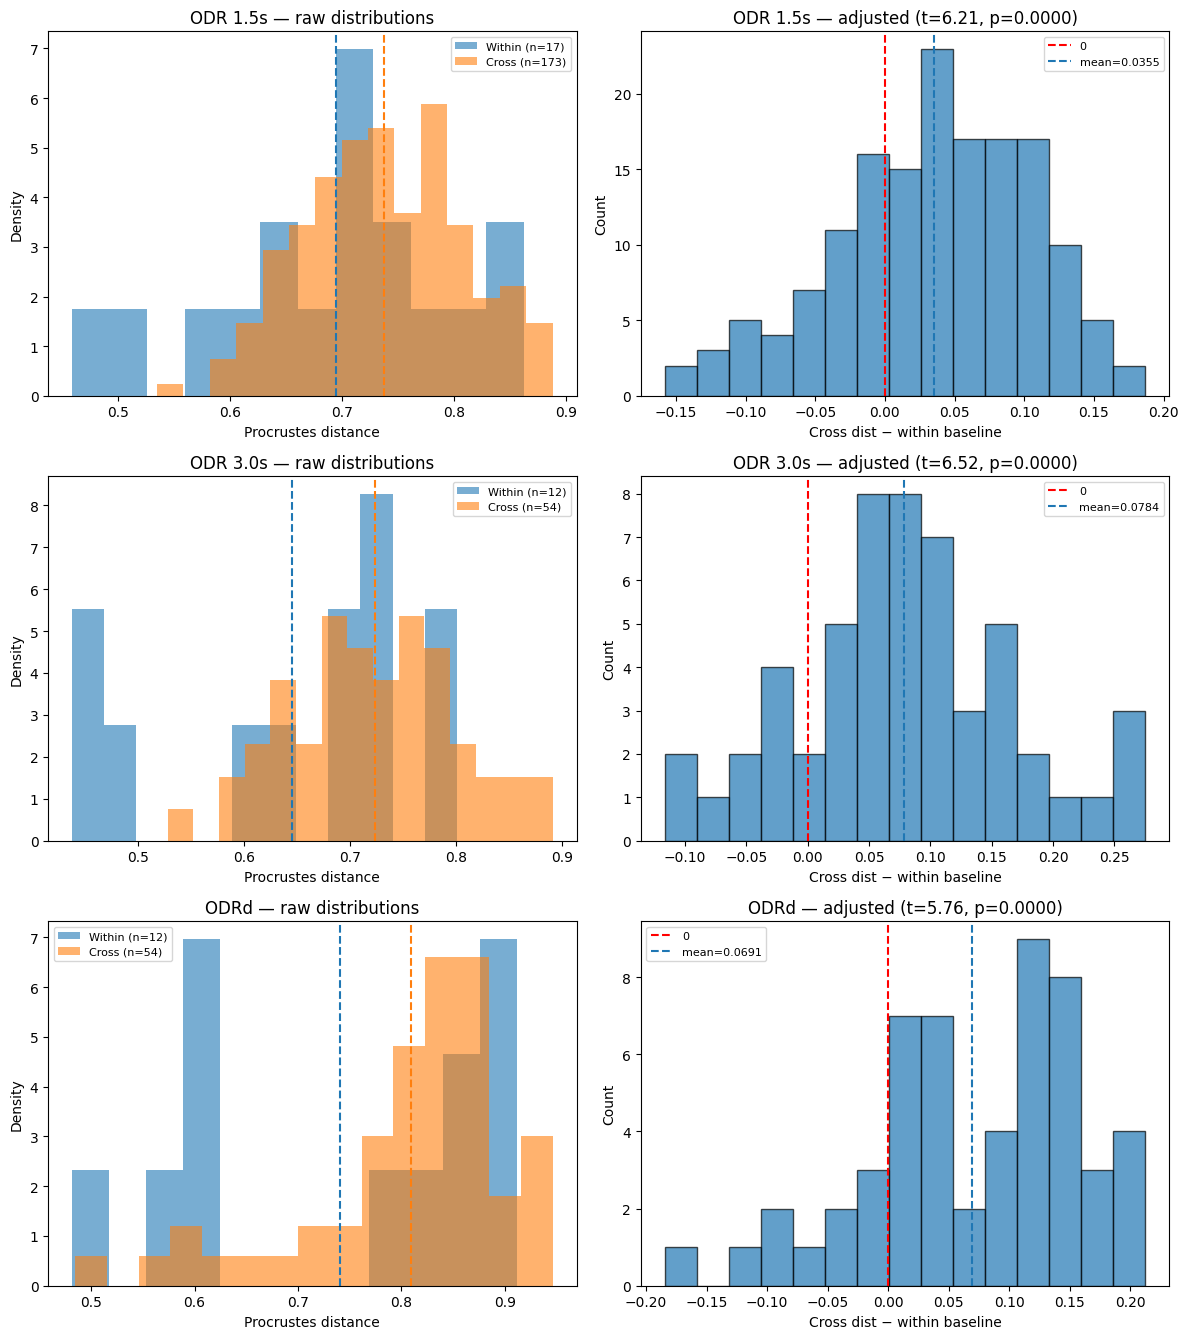

In [7]:
plot_cross_monkey(results)

## 5. Distance matrices

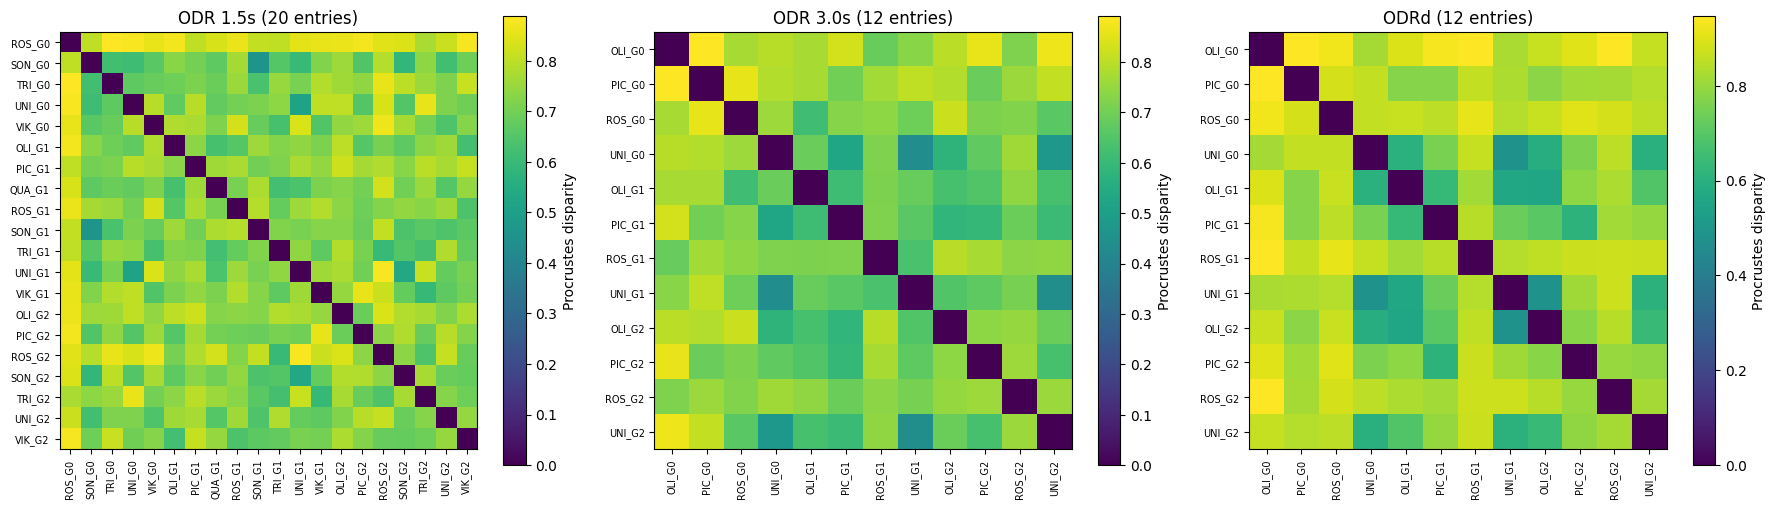

In [8]:
plot_distance_matrices(results)

## 6. Cross-age analysis

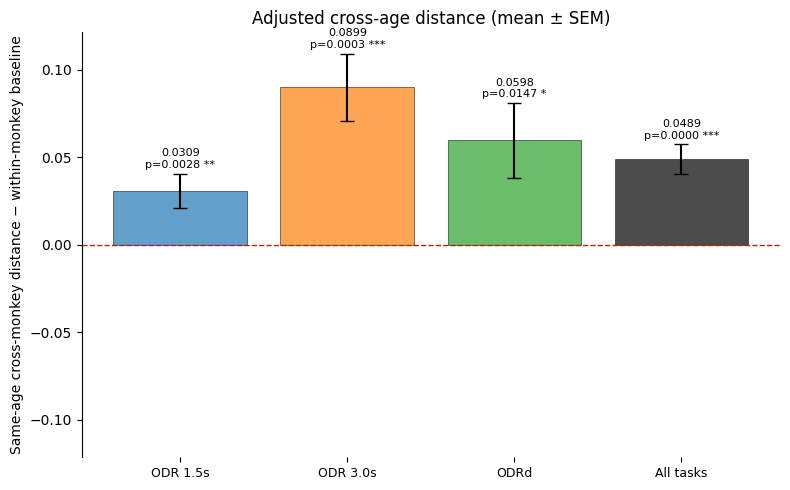

In [9]:
#plot_cross_age(results)
plot_cross_age_bars(results)

## 6b. Cross-monkey distance (common monkeys only)

ODR 1.5s: 5/8 monkeys in all 3 groups ([np.str_('ROS'), np.str_('SON'), np.str_('TRI'), np.str_('UNI'), np.str_('VIK')]), 961/1180 neurons
  young: 10 pairs
  middle: 10 pairs
  old: 10 pairs
  regression: slope=-0.0146 +/- 0.0161, r=-0.169, p=0.3714
ODR 3.0s: 4/4 monkeys in all 3 groups ([np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]), 922/922 neurons
  young: 6 pairs
  middle: 6 pairs
  old: 6 pairs
  regression: slope=-0.0451 +/- 0.0192, r=-0.507, p=0.0319
ODRd: 4/4 monkeys in all 3 groups ([np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]), 1319/1319 neurons
  young: 6 pairs
  middle: 6 pairs
  old: 6 pairs
  regression: slope=-0.0522 +/- 0.0270, r=-0.435, p=0.0716

All tasks pooled: slope=-0.0332 +/- 0.0123, r=-0.319, p=0.0090


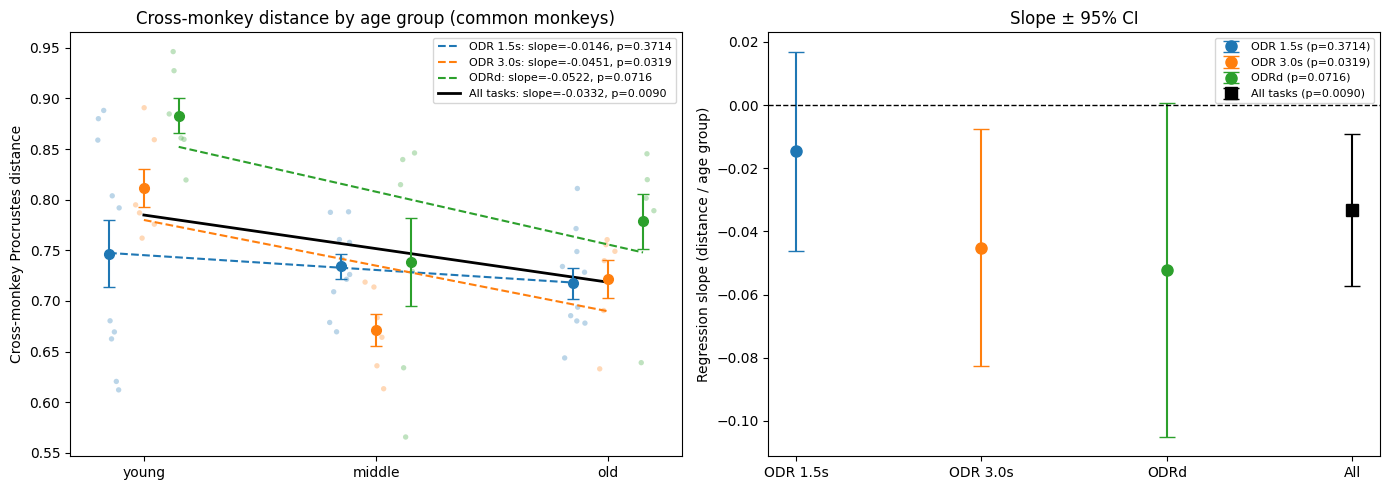

In [10]:
results_by_group, pooled = cross_monkey_by_group(
    task_data, psth_data, age_groups, N_PCS, MIN_NEURONS, AGE_GROUP_LABELS)

plot_cross_monkey_by_group(results_by_group, pooled, AGE_GROUP_LABELS)

## 8. Behavioral vs neural distance correlations (DI, RT)

In [11]:
beh_df = load_behavioral_data(BEH_SAC, sac_odrd_path=BEH_SAC_ODRD)

beh_dist = {}
for task_name in results:
    R = results[task_name]
    di_dist, rt_dist, di_vals, rt_vals = behavioral_distance_matrices(
        beh_df, R['entries'], AGE_EDGES, task_name)
    beh_dist[task_name] = dict(di_dist=di_dist, rt_dist=rt_dist,
                               di_vals=di_vals, rt_vals=rt_vals)
    n = len(R['entries'])
    print(f'{task_name} ({n} entries): '
          f'DI valid {np.sum(np.isfinite(di_vals))}/{n}, '
          f'RT valid {np.sum(np.isfinite(rt_vals))}/{n}')

ODR 1.5s (20 entries): DI valid 20/20, RT valid 20/20
ODR 3.0s (12 entries): DI valid 12/12, RT valid 12/12
ODRd (12 entries): DI valid 12/12, RT valid 12/12


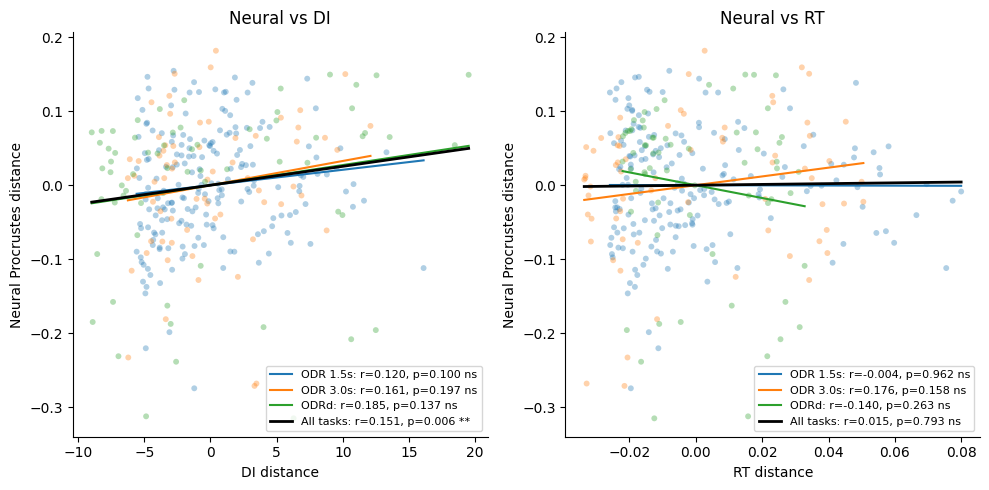

In [12]:
plot_behavior_neural_bars(results, beh_dist)